In [1]:
import os.path
import glob
import pandas as pd
from biom import Table, load_table

import warnings

from qiime2.plugins.feature_table.methods import (rarefy, filter_samples, filter_features,
                                                  merge)
from qiime2.plugins.feature_table.methods import filter_features_conditionally
from qiime2.plugins.feature_table.visualizers import summarize

from qiime2 import Artifact
from qiime2 import Metadata


from skbio import OrdinationResults, TreeNode, DistanceMatrix
# from qiime2.plugins.gemelli.actions import (rpca, phylogenetic_rpca_without_taxonomy,
#                                             phylogenetic_rpca_with_taxonomy)
from qiime2.plugins.emperor.actions import plot, biplot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.pipelines import (alpha,
                                                alpha_phylogenetic)
from qiime2.plugins.diversity.visualizers import (alpha_rarefaction,adonis,beta_group_significance)
from qiime2.plugins.diversity.methods import pcoa
from qiime2.plugins import taxa

from qiime2.plugins import emperor
from qiime2.plugins.empress.actions import community_plot

from assets.step_wise_anova import run_stepwise_anova

from skbio.stats.distance import permanova, bioenv
import statsmodels.stats.multitest as multi 
from scipy.optimize import curve_fit
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import re

In [2]:
# classifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import (roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
# stats
from statsmodels.stats.contingency_tables import mcnemar

# Importing files

In [3]:
gg2_ft = Artifact.load('./data/katharo_deblur_gg2_feature_table.qza')

In [4]:
gg2_taxonomy = Artifact.load('./data/gg2_taxonomy.qza')

In [5]:
gg2_taxonomy_df = gg2_taxonomy.view(pd.DataFrame)

In [6]:
gg2_tree = Artifact.load('./data/2022.10.phylogeny.asv.nwk.qza')

In [7]:
##Updated. Need to update metadata in Qiita study
metadata = Metadata.load('./metadata/2023_03_21_3DMM_metadata_to_update_qiita.txt')

In [8]:
# feature_metadata = Metadata.load('./metadata/taxonomy.tsv')
gg2_feature_metadata = Metadata.load('./metadata/gg2_taxonomy.tsv')

In [9]:
metadata_df = metadata.to_dataframe()

In [10]:
module_colors= {'Airlock':'tab:red',
               'Columbus':'tab:blue',
               'JLP':'tab:orange',
               'JPM':'tab:green',
               'US Lab':'cadetblue',
               'Node 1':'tab:purple',
               'Node 2':'yellow',
               'Node 3':'tab:cyan',
               'PMM':'tab:pink'}

# SourceTracking2

In [11]:
st2_metadata = pd.read_csv('./metadata/sourcetracker_metadata.tsv',sep='\t')

In [12]:
for index, row in st2_metadata.iterrows():
    st2_metadata.loc[index,'study_id'] = row['#SampleID'].split('.')[0] 

In [13]:
# Sample counts by qiita study_id, and environment. 
st2_metadata.groupby('study_id').Env.value_counts().sort_values()

study_id  Env               
1024      Soil (non-saline)       1
889       Water (saline)          1
755       Water (non-saline)      1
662       Water (saline)          1
1883      Soil (non-saline)       1
1713      Soil (non-saline)       1
1714      Soil (non-saline)       1
1041      Water (non-saline)      2
1716      Soil (non-saline)       2
1717      Soil (non-saline)       2
1711      Soil (non-saline)       3
1715      Soil (non-saline)       3
1289      Soil (non-saline)       4
2382      Soil (non-saline)       4
1883      Water (saline)          4
1674      Soil (non-saline)       5
861       Water (saline)          6
1721      Soil (non-saline)       7
864       Soil (non-saline)      14
1883      Water (non-saline)     21
1222      Water (saline)         25
723       Water (saline)         26
2080      Water (saline)         26
990       Soil (non-saline)      38
1240      Water (saline)         45
945       Water (non-saline)     48
755       Soil (non-saline)      48

In [14]:
#Importing SourceTracker2 output. 
#SourceTracer2 was run on qiime2 CLI
m_proportions = Artifact.load('./data/mixing_proportions.qza')

In [15]:
proportions_df = m_proportions.view(pd.DataFrame).T.merge(metadata_df,
                                                          left_index=True,right_on='original_SampleID')

In [16]:
colors = ['olive','cornflowerblue','slateblue',
         'indianred','tab:brown','forestgreen','tab:cyan',
          'plum','tan','gold','grey']
explode = (0.2,0.2,0.2,0,0,0,0,0,0,0,0)
legend_labels = list(m_proportions.view(pd.DataFrame).index.str.lower())

In [17]:
source_df = pd.DataFrame([])
for source in m_proportions.view(pd.DataFrame).index:
    block_ = pd.DataFrame(np.array(proportions_df[source]))
    block_['source_env'] = source
    source_df = source_df.append(block_)

In [18]:
source_df['source_env'].unique()

array(['Soil (non-saline)', 'Water (non-saline)', 'Water (saline)',
       'building materials', 'feces', 'food', 'nose', 'oral cavity',
       'skin', 'urine', 'Unknown'], dtype=object)

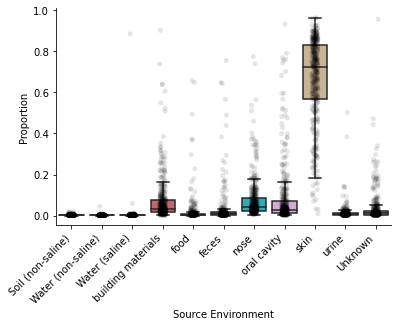

In [19]:
f, (ax) = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
order_ = ['Soil (non-saline)', 'Water (non-saline)', 'Water (saline)',
       'building materials',  'food','feces', 'nose', 'oral cavity',
       'skin', 'urine', 'Unknown']
sns.boxplot(x='source_env',y=0,data=source_df,fliersize=0,order=order_,
        palette=colors,ax=ax)
sns.stripplot(x='source_env',y=0,data=source_df,order=order_,color='black',alpha=0.1,ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=45,ha='right',va='top')
plt.xlabel('Source Environment')
plt.ylabel('Proportion')
plt.savefig('./figs/st2_proportions_boxplot.svg')

In [20]:
proportions_df['building materials'].describe()

count    393.000000
mean       0.073201
std        0.110080
min        0.001100
25%        0.017300
50%        0.033800
75%        0.078000
max        0.903000
Name: building materials, dtype: float64

In [21]:
module_colors= {'Airlock':'tab:red',
               'Columbus':'tab:blue',
               'JLP':'tab:orange',
               'JPM':'tab:green',
               'US Lab':'cadetblue',
               'Node 1':'tab:purple',
               'Node 2':'yellow',
               'Node 3':'tab:cyan',
               'PMM':'tab:pink'}

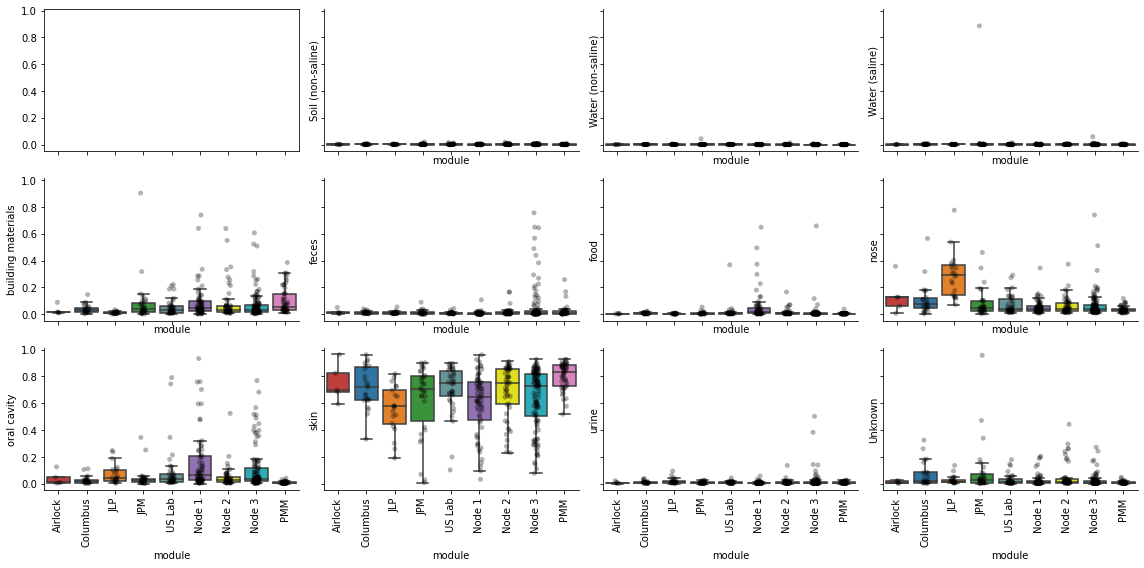

In [22]:
#Figure S3A-K
##setup subplots, 10 potential source environments + 1 unknown bin. 
index=1
rows=3
columns=4
f, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(16,8),sharey=True,sharex=True)
#plt.subplots_adjust(hspace=0.3)

labels = ['Airlock','Columbus','JLP','JPM','US Lab','Node 1','Node 2','Node 3','PMM']

for source in m_proportions.view(pd.DataFrame).index:
    sns.boxplot(x='module',y=source,data=proportions_df,palette=module_colors,
                 ax= axes[index//columns,index%columns],fliersize=0)
    sns.stripplot(x='module',y=source,data=proportions_df,
                 ax= axes[index//columns,index%columns],color='black',alpha=0.3)
    axes[index//columns,index%columns].set_xticklabels(labels,rotation=90)
    axes[index//columns,index%columns].spines['right'].set_visible(False)
    axes[index//columns,index%columns].spines['left'].set_visible(True)
    axes[index//columns,index%columns].spines['bottom'].set_visible(True)
    axes[index//columns,index%columns].spines['top'].set_visible(False)
    index+=1
plt.tight_layout()
plt.savefig('./figs/st2_proportions_per_module.svg')

# EMPress

Using EMPRess vsiualization tool to evaluate the prevalence of features observed on ISS among source tracking environments. 

In [23]:
# SourceTracing2 analysis, collapsed at Genera
st2_ft_gc = Artifact.load('./data/sourcetracker_table_genuslevel.qza')
st2_gc_tree = Artifact.load('./data/sourcetracker_table_genuslevel_tree.qza')
st2_metadata = Metadata.load('./metadata/sourcetracker_metadata.tsv')
gg2_no_controls_rarefied = Artifact.load('./data/katharo_deblur_gg2_feature_table_no_controls_rarefied.qza')

In [24]:
st2_metadata

Metadata
--------
1732 IDs x 2 columns
Env:        ColumnProperties(type='categorical')
SourceSink: ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation.

In [25]:
st2_ft_gc.view(Table)

4780 x 1732 <class 'biom.table.Table'> with 226619 nonzero entries (2% dense)

In [26]:
# Exclusive subset of ISS samples from SourceTracing analysis 
st2_ft_gc_f_iss = filter_samples(st2_ft_gc,metadata=st2_metadata, where='Env == "ISS"',
                                exclude_ids=False).filtered_table

In [27]:
# Feature space of ISS from SourceTracing analysis 
features_3DMM_gc = pd.DataFrame(st2_ft_gc_f_iss.view(pd.DataFrame).columns)
features_3DMM_gc.rename(columns={0:'Feature ID'}).set_index('Feature ID').to_csv('./metadata/3DMM_features_gc.tsv',
                                                                             sep='\t')
features_3DMM_gc = Metadata.load('./metadata/3DMM_features_gc.tsv')

In [28]:
#Calculate counts per genera
counts_df = pd.DataFrame(st2_ft_gc_f_iss.view(pd.DataFrame).sum()).rename(columns={0:'Counts'})
counts_df['log_counts'] = np.log10(counts_df['Counts'])
gg2_feature_metadata_df = gg2_feature_metadata.to_dataframe()
for genus in counts_df.index:
    taxon = gg2_feature_metadata_df.loc[gg2_feature_metadata_df['Taxon'].str.contains(genus),'Taxon'][0]
    counts_df.loc[genus,'Taxon']=taxon
counts_df.rename_axis('Feature ID').to_csv('./metadata/3DMM_feature_counts_gc.tsv',
                                                                             sep='\t')

counts_metadata = Metadata.load('./metadata/3DMM_feature_counts_gc.tsv')

In [29]:
#3DMM counts (genera collapsed) sanity check.
counts_metadata.to_dataframe().sort_values(by='Counts')

,Counts,log_counts,Taxon
Feature ID,,,
g__Heyndrickxia,1.0,0.000000,d__Bacteria; p__Firmicutes_D; c__Bacilli; o__B...
g__Pseudoclavibacter_A_383750,1.0,0.000000,d__Bacteria; p__Actinobacteriota; c__Actinomyc...
g__Dickeya_725901,1.0,0.000000,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
g__Bacillus_AZ_295450,1.0,0.000000,d__Bacteria; p__Firmicutes_D; c__Bacilli; o__B...
g__Azomonas_648163,1.0,0.000000,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
...,...,...,...
g__Streptococcus,505326.0,5.703572,d__Bacteria; p__Firmicutes_D; c__Bacilli; o__L...
g__Pantoea_A_679409; s__Pantoea septica,607001.0,5.783189,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
g__Corynebacterium,1221798.0,6.086999,d__Bacteria; p__Actinobacteriota; c__Actinomyc...


In [30]:
counts_3DMM = pd.DataFrame(gg2_no_controls_rarefied.view(pd.DataFrame).sum()).rename(columns={0:'Counts'}).rename_axis('Feature ID')

In [31]:
gg2_feature_metadata_wc = gg2_feature_metadata.to_dataframe().merge(counts_3DMM,
                                                                    left_index=True,
                                                                    right_index=True,
                                                                    how='left')

In [32]:
#3DMM counts (sOTU level) sanity check.
#Top genera by counts roughly matches data resolved at sOTU level. 
gg2_feature_metadata_wc.sort_values(by='Counts',na_position='first')['Taxon'].tail(5).values

array(['d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Mycobacteriales; f__Mycobacteriaceae; g__Lawsonella; s__Lawsonella clevelandensis',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales_660879; f__Moraxellaceae; g__; s__',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales_A_737866; f__Enterobacteriaceae_A; g__Pantoea_A_679409; s__Pantoea septica',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales_650611; f__Pseudomonadaceae; g__Pseudomonas_O_647615; s__Pseudomonas_O_647615 parafulva',
       'd__Bacteria; p__Firmicutes_D; c__Bacilli; o__Staphylococcales; f__Staphylococcaceae; g__Staphylococcus; s__Staphylococcus caprae'],
      dtype=object)

In [33]:
#Exclude 3DMM samples for prevalence barplotting
st2_ft_gc_f = filter_samples(st2_ft_gc,metadata=st2_metadata, where='Env == "ISS"',
                                exclude_ids=True).filtered_table
st2_ft_gc_f.view(Table)

4718 x 1340 <class 'biom.table.Table'> with 183953 nonzero entries (2% dense)

In [34]:
#Subset SourceTracker2 analysis feature space to only represent features observed in 3DMM samples 
st2_ft_gc_ff = filter_features(st2_ft_gc_f,metadata=features_3DMM_gc).filtered_table
st2_ft_gc_ff.view(Table)

1248 x 1340 <class 'biom.table.Table'> with 110198 nonzero entries (6% dense)

In [35]:
st2_gc_empress = community_plot(st2_gc_tree,
                                   st2_ft_gc_ff,
                                   sample_metadata=st2_metadata,
                                feature_metadata=counts_metadata,
                                   ignore_missing_samples=True,
                                   filter_extra_samples=False,
                                   filter_missing_features=True)

/Users/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/empress/tools.py:251: DataMatchingWarning: 626 feature(s) in the table were not present as tips in the tree. These feature(s) have been removed from the visualization.
  warnings.warn(


Removed 3 empty sample(s).


In [36]:
st2_gc_empress.visualization.save('./output/st2_empress_gc.qzv')

'./output/st2_empress_gc.qzv'

In [37]:
#Quantitative analysis of g__Staphylococcus prevalence among potential source environments

In [38]:
#Per sample read counts
st2_ft_gc_ff.view(pd.DataFrame).sum(axis=1)

11442.G72461                                                     132915.0
11442.G72480                                                     658667.0
11442.G72506                                                      43342.0
11442.G72517                                                     171691.0
11442.G72527                                                     115351.0
                                                                   ...   
1883.2011.291.Crump.Artic.LTREB.main.lane4.NoIndex                 1241.0
2382.SH008.C6.HA.1.726.bulk.9.12.lane7.NoIndex.L007.sequences     16428.0
2382.SH007.C6.RH.1.501.bulk.4.12.lane7.NoIndex.L007.sequences     17623.0
2382.MU002.C3.HA.2.681.bulk.9.12.lane7.NoIndex.L007.sequences     13812.0
2382.DPOO1.C1.HA.5.646.bulk.9.12.lane7.NoIndex.L007.sequences     15173.0
Length: 1340, dtype: float64

In [39]:
st2_ft_gc_ff_rare = rarefy(st2_ft_gc_ff,sampling_depth=1000).rarefied_table
st2_ft_gc_ff_rare.view(Table)

1180 x 1317 <class 'biom.table.Table'> with 61375 nonzero entries (3% dense)

In [40]:
staph_pos = st2_ft_gc_ff_rare.view(pd.DataFrame).loc[st2_ft_gc_ff_rare.view(pd.DataFrame)['g__Staphylococcus']>0].index

In [41]:
len(staph_pos)

514

In [42]:
st2_metadata_df =st2_metadata.to_dataframe()

In [43]:
st2_metadata_df.loc[st2_metadata_df.index.isin(staph_pos)]['Env'].value_counts()

nose                  130
skin                  129
urine                  86
building materials     51
food                   42
oral cavity            25
Water (non-saline)     19
Water (saline)         17
feces                   8
Soil (non-saline)       7
Name: Env, dtype: int64

In [44]:
#Some stoichiometric differences between these numbers and those from publised paper can be attributed to 
#rarefaction @ 1000 sequences per sample. 
prevalence_df = st2_metadata_df.loc[st2_metadata_df.index.isin(staph_pos)]['Env'].value_counts()/st2_metadata_df['Env'].value_counts()
prevalence_df.sort_values(ascending=False)

nose                  0.970149
skin                  0.962687
urine                 0.641791
building materials    0.380597
food                  0.313433
oral cavity           0.186567
Water (non-saline)    0.141791
Water (saline)        0.126866
feces                 0.059701
Soil (non-saline)     0.052239
ISS                        NaN
Name: Env, dtype: float64